<a href="https://colab.research.google.com/github/YamenHabib/Knowledge-Distillation/blob/main/KD_103.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from copy import deepcopy
import os
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
import datetime
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
train_data = datasets.CIFAR10("CIFAR10", train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10("CIFAR10", train=False, transform=transform_test)


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10


In [5]:
len(train_data), len(test_data)

(50000, 10000)

In [6]:
train_loader = torch.utils.data.DataLoader(train_data , batch_size=32, shuffle=True )
test_loader = torch.utils.data.DataLoader(test_data , batch_size=32, shuffle=True)

In [7]:
class TecherModel(nn.Module):
    def __init__(self):
        super(TecherModel, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 5
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x

In [8]:
teacher_model = TecherModel()

In [9]:
teacher_model(iter(train_loader).next()[0]).shape

torch.Size([32, 10])

In [43]:
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.02, inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(2048, 10),
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [44]:
student_model = StudentModel()

In [45]:
student_model(iter(train_loader).next()[0]).shape

torch.Size([32, 10])

In [46]:
distilled_student_model = StudentModel()

In [47]:
class KD:
    def __init__( self, teacher_model, student_model, distilled_student_model,
                  train_loader, val_loader,
                  loss_fn=nn.KLDivLoss(reduction='batchmean'), temp=20.0, distil_weight=0.5, log=False, logdir="./Experiments"):

        self.train_loader, self.val_loader = train_loader, val_loader
        self.temp = temp
        self.distil_weight = distil_weight
        self.logdir = logdir
        self.teacher_model = teacher_model.to(device)
        self.student_model = student_model.to(device)
        self.distilled_student_model = distilled_student_model.to(device)
        self.optimizer_teacher = optim.SGD(teacher_model.parameters(), 0.01)
        self.optimizer_student = optim.SGD(student_model.parameters(), 0.01)
        self.optimizer_distilled_student = optim.SGD(self.distilled_student_model.parameters(), 0.05)

        self.loss_fn = loss_fn.to(device)
        self.ce_fn = nn.CrossEntropyLoss(reduction='mean').to(device)
        


    def train_teacher( self, epochs=20, save_model_pth="./models/teacher.pt"):
        self.teacher_model = self.teacher_model.to(device)
        self.teacher_model.train()
        train_loss_arr = []
        val_loss_arr = []
        best_val_acc = 0.0
        self.best_teacher_model_weights = deepcopy(self.teacher_model.state_dict())

        save_dir = os.path.dirname(save_model_pth)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        for ep in range(epochs):
            train_epoch_loss = 0.0
            val_epoch_loss = 0.0
            train_correct = 0.0
            val_correct = 0.0

            self.teacher_model.train()
            for (data, label) in self.train_loader:
                data = data.to(device)
                label = label.to(device)
                out = self.teacher_model(data)
                pred = out.argmax(dim=1, keepdim=True)
                train_correct += pred.eq(label.view_as(pred)).sum().item()
                loss = self.ce_fn(out, label)
                self.optimizer_teacher.zero_grad()
                loss.backward()
                self.optimizer_teacher.step()
                train_epoch_loss += loss.item()
            
            train_epoch_acc = train_correct / len(self.train_loader.dataset)
            train_epoch_loss /= len(self.train_loader.dataset)

            with torch.no_grad():
              self.teacher_model.eval()
              for (data, label) in self.val_loader:
                  data = data.to(device)
                  label = label.to(device)
                  out = self.teacher_model(data)
                  pred = out.argmax(dim=1, keepdim=True)
                  val_correct += pred.eq(label.view_as(pred)).sum().item()
                  loss = self.ce_fn(out, label)
                  val_epoch_loss += loss.item()
            
            val_epoch_acc = val_correct / len(self.val_loader.dataset)
            val_epoch_loss /= len(self.val_loader.dataset)

            if val_epoch_acc > best_val_acc:
                best_val_acc = val_epoch_acc
                self.best_teacher_model_weights = deepcopy( self.teacher_model.state_dict())

            train_loss_arr.append(train_epoch_loss)
            val_loss_arr.append(val_epoch_loss)
            print(f"Epoch: {ep+1}, Train Loss: {train_epoch_loss:4.4f},"
                  f" Val Loss: {val_epoch_loss:4.4f}, Train-Accuracy: {train_epoch_acc: 4.4f},"
                  f" Val-Accuracy: {val_epoch_acc:4.4f}, Time: {datetime.datetime.now()}")

        self.teacher_model.load_state_dict(self.best_teacher_model_weights)
        torch.save(self.teacher_model.state_dict(), save_model_pth)
        plt.plot(train_loss_arr, label='Train')
        plt.plot(val_loss_arr, label='Validation')
        
    def train_student( self, epochs=20,  save_model_pth="./models/student.pt"):
        self.student_model = self.student_model.to(device)
        self.student_model.train()
        train_loss_arr = []
        val_loss_arr = []
        best_val_acc = 0.0
        self.best_student_model_weights = deepcopy(self.student_model.state_dict())

        save_dir = os.path.dirname(save_model_pth)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        for ep in range(epochs):
            train_epoch_loss = 0.0
            val_epoch_loss = 0.0
            train_correct = 0.0
            val_correct = 0.0

            self.student_model.train()
            for (data, label) in self.train_loader:
                data = data.to(device)
                label = label.to(device)
                out = self.student_model(data)
                pred = out.argmax(dim=1, keepdim=True)
                train_correct += pred.eq(label.view_as(pred)).sum().item()
                loss = self.ce_fn(out, label)
                self.optimizer_student.zero_grad()
                loss.backward()
                self.optimizer_student.step()
                train_epoch_loss += loss
            
            train_epoch_loss /= len(self.train_loader.dataset)
            train_epoch_acc = train_correct / len(self.train_loader.dataset)

            with torch.no_grad():
              self.student_model.eval()
              for (data, label) in self.val_loader:
                  data = data.to(device)
                  label = label.to(device)
                  out = self.student_model(data)
                  pred = out.argmax(dim=1, keepdim=True)
                  val_correct += pred.eq(label.view_as(pred)).sum().item()
                  loss = self.ce_fn(out, label)
                  val_epoch_loss += loss
            
            val_epoch_acc = val_correct / len(self.val_loader.dataset)
            val_epoch_loss /= len(self.val_loader.dataset)
            if val_epoch_acc > best_val_acc:
                best_val_acc = val_epoch_acc
                self.best_student_model_weights = deepcopy( self.student_model.state_dict())

            train_loss_arr.append(train_epoch_loss)
            val_loss_arr.append(val_epoch_loss)
            
            
            print(f"Epoch: {ep+1}, Train Loss: {train_epoch_loss:4.4f},"
                  f" Val Loss: {val_epoch_loss:4.4f}, Train-Accuracy: {train_epoch_acc: 4.4f},"
                  f" Val-Accuracy: {val_epoch_acc:4.4f}, Time: {datetime.datetime.now()}")

        self.student_model.load_state_dict(self.best_student_model_weights)
        torch.save(self.student_model.state_dict(), save_model_pth)
        plt.plot(train_loss_arr, label='Train')
        plt.plot(val_loss_arr, label='Validation')

    def distile_student(self, epochs=10, save_model_pth="./models/student_distil.pt"):
        self.distilled_student_model = self.distilled_student_model.to(device)
        self.teacher_model = self.teacher_model.to(device).eval()
        train_loss_arr = []
        val_loss_arr = []
        best_val_acc = 0.0
        self.best_distilled_student_model_weights = deepcopy(self.distilled_student_model.state_dict())

        save_dir = os.path.dirname(save_model_pth)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        for ep in range(epochs):
            train_epoch_loss = 0.0
            val_epoch_loss = 0.0
            train_correct = 0.0
            val_correct = 0.0

            self.distilled_student_model.train()
            for (data, label) in self.train_loader:
                data = data.to(device)
                label = label.to(device)
                student_out = self.distilled_student_model(data)
                teacher_out = self.teacher_model(data)
                pred = student_out.argmax(dim=1, keepdim=True)
                train_correct += pred.eq(label.view_as(pred)).sum().item()
                loss = self.calculate_kd_loss(student_out, teacher_out, label)
                # loss = self.ce_fn(student_out, label)
                self.optimizer_distilled_student.zero_grad()
                loss.backward()
                self.optimizer_distilled_student.step()
                train_epoch_loss += loss
            
            train_epoch_loss /= len(self.train_loader.dataset)
            train_epoch_acc = train_correct / len(self.train_loader.dataset)

            with torch.no_grad():
              self.distilled_student_model.eval()
              for (data, label) in self.val_loader:
                  data = data.to(device)
                  label = label.to(device)
                  student_out = self.distilled_student_model(data)
                  teacher_out = self.teacher_model(data)
                  pred = student_out.argmax(dim=1, keepdim=True)
                  val_correct += pred.eq(label.view_as(pred)).sum().item()
                  loss = self.calculate_kd_loss(student_out, teacher_out, label)
                  # loss = self.ce_fn(student_out, label)
                  val_epoch_loss += loss
            
            val_epoch_acc = val_correct / len(self.val_loader.dataset)
            val_epoch_loss /= len(self.val_loader.dataset)
            if val_epoch_acc > best_val_acc:
                best_val_acc = val_epoch_acc
                self.best_distilled_student_model_weights = deepcopy( self.distilled_student_model.state_dict())

            train_loss_arr.append(train_epoch_loss)
            val_loss_arr.append(val_epoch_loss)
            
            
            print(f"Epoch: {ep+1}, Train Loss: {train_epoch_loss:4.4f},"
                  f" Val Loss: {val_epoch_loss:4.4f}, Train-Accuracy: {train_epoch_acc: 4.4f},"
                  f" Val-Accuracy: {val_epoch_acc:4.4f}, Time: {datetime.datetime.now()}")

        self.distilled_student_model.load_state_dict(self.best_distilled_student_model_weights)
        torch.save(self.distilled_student_model.state_dict(), save_model_pth)
        plt.plot(train_loss_arr, label='Train')
        plt.plot(val_loss_arr, label='Validation')

    def calculate_kd_loss(self, y_pred_student, y_pred_teacher, y_true):
        soft_teacher_out = F.softmax(y_pred_teacher / self.temp, dim=1)
        soft_student_out = F.softmax(y_pred_student / self.temp, dim=1)

        loss = (1 - self.distil_weight) * F.cross_entropy(y_pred_student, y_true)
        loss += (self.distil_weight * self.temp * self.temp) * self.loss_fn( soft_teacher_out, soft_student_out)
        return loss

    def _evaluate_model(self, model, verbose=True):
        model.eval()
        model.to(device)
        length_of_dataset = len(self.val_loader.dataset)
        correct = 0
        outputs = []

        with torch.no_grad():
            for data, target in self.val_loader:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                outputs.append(output)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        acc = correct / length_of_dataset
        return acc


    def evaluate_student(self, distiled=False):
        if distiled:
            model = deepcopy(self.distilled_student_model).to(device)
        else:
            model = deepcopy(self.student_model).to(device)
        acc = self._evaluate_model(model)
        return acc

    def evaluate_teacher(self):
        model = deepcopy(self.teacher_model).to(device)
        acc = self._evaluate_model(model)
        return acc

    def get_parameters(self):
        teacher_params = sum(p.numel() for p in self.teacher_model.parameters())
        student_params = sum(p.numel() for p in self.student_model.parameters())

        print("-" * 80)
        print(f"teacher'parameters : {teacher_params}")
        print(f"student'parameters : {student_params}")
        print(f"Percentage of Student/Teacher is: {student_params/teacher_params * 100:.2f} %")

# Load Models or train them.

In [48]:
distiller = KD(teacher_model, student_model, distilled_student_model, train_loader, test_loader)

In [49]:
distiller.get_parameters()

--------------------------------------------------------------------------------
teacher'parameters : 19357706
student'parameters : 1771786
Percentage of Student/Teacher is: 9.15 %


Epoch: 1, Train Loss: 0.0471, Val Loss: 0.0401, Train-Accuracy:  0.4378, Val-Accuracy: 0.5474, Time: 2021-05-18 08:24:36.285113
Epoch: 2, Train Loss: 0.0312, Val Loss: 0.0284, Train-Accuracy:  0.6451, Val-Accuracy: 0.6833, Time: 2021-05-18 08:25:30.704495
Epoch: 3, Train Loss: 0.0246, Val Loss: 0.0209, Train-Accuracy:  0.7268, Val-Accuracy: 0.7674, Time: 2021-05-18 08:26:25.441064
Epoch: 4, Train Loss: 0.0208, Val Loss: 0.0221, Train-Accuracy:  0.7686, Val-Accuracy: 0.7622, Time: 2021-05-18 08:27:20.586118
Epoch: 5, Train Loss: 0.0183, Val Loss: 0.0183, Train-Accuracy:  0.7986, Val-Accuracy: 0.8000, Time: 2021-05-18 08:28:15.859746
Epoch: 6, Train Loss: 0.0167, Val Loss: 0.0165, Train-Accuracy:  0.8170, Val-Accuracy: 0.8226, Time: 2021-05-18 08:29:11.187865
Epoch: 7, Train Loss: 0.0152, Val Loss: 0.0173, Train-Accuracy:  0.8309, Val-Accuracy: 0.8099, Time: 2021-05-18 08:30:06.477211
Epoch: 8, Train Loss: 0.0141, Val Loss: 0.0157, Train-Accuracy:  0.8441, Val-Accuracy: 0.8297, Time: 202

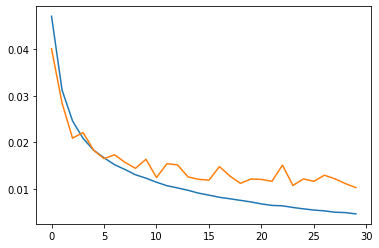

In [23]:
distiller.train_teacher(epochs=30)

Epoch: 1, Train Loss: 0.0447, Val Loss: 0.0352, Train-Accuracy:  0.4728, Val-Accuracy: 0.5983, Time: 2021-05-18 10:09:49.198262
Epoch: 2, Train Loss: 0.0314, Val Loss: 0.0273, Train-Accuracy:  0.6407, Val-Accuracy: 0.6933, Time: 2021-05-18 10:10:11.376293
Epoch: 3, Train Loss: 0.0261, Val Loss: 0.0258, Train-Accuracy:  0.7060, Val-Accuracy: 0.7134, Time: 2021-05-18 10:10:33.552040
Epoch: 4, Train Loss: 0.0230, Val Loss: 0.0264, Train-Accuracy:  0.7423, Val-Accuracy: 0.7125, Time: 2021-05-18 10:10:55.495519
Epoch: 6, Train Loss: 0.0194, Val Loss: 0.0208, Train-Accuracy:  0.7824, Val-Accuracy: 0.7697, Time: 2021-05-18 10:11:39.425136
Epoch: 7, Train Loss: 0.0180, Val Loss: 0.0206, Train-Accuracy:  0.8008, Val-Accuracy: 0.7745, Time: 2021-05-18 10:12:01.333094
Epoch: 8, Train Loss: 0.0168, Val Loss: 0.0181, Train-Accuracy:  0.8136, Val-Accuracy: 0.8051, Time: 2021-05-18 10:12:23.421585
Epoch: 10, Train Loss: 0.0151, Val Loss: 0.0167, Train-Accuracy:  0.8330, Val-Accuracy: 0.8187, Time: 20

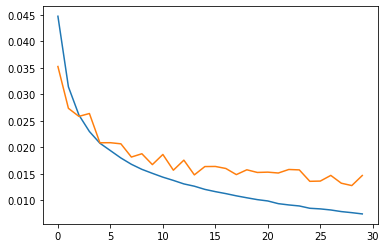

In [50]:
distiller.train_student(epochs=30)

Epoch: 1, Train Loss: -14.9988, Val Loss: -15.0206, Train-Accuracy:  0.5277, Val-Accuracy: 0.6007, Time: 2021-05-18 10:22:03.643139
Epoch: 2, Train Loss: -15.0051, Val Loss: -15.0246, Train-Accuracy:  0.6933, Val-Accuracy: 0.6905, Time: 2021-05-18 10:22:58.201142
Epoch: 3, Train Loss: -15.0073, Val Loss: -15.0253, Train-Accuracy:  0.7459, Val-Accuracy: 0.7085, Time: 2021-05-18 10:23:52.990232
Epoch: 4, Train Loss: -15.0085, Val Loss: -15.0282, Train-Accuracy:  0.7823, Val-Accuracy: 0.7718, Time: 2021-05-18 10:24:47.829176
Epoch: 5, Train Loss: -15.0094, Val Loss: -15.0286, Train-Accuracy:  0.8027, Val-Accuracy: 0.7788, Time: 2021-05-18 10:25:42.550214
Epoch: 6, Train Loss: -15.0100, Val Loss: -15.0303, Train-Accuracy:  0.8164, Val-Accuracy: 0.8265, Time: 2021-05-18 10:26:37.314396
Epoch: 7, Train Loss: -15.0105, Val Loss: -15.0293, Train-Accuracy:  0.8294, Val-Accuracy: 0.7994, Time: 2021-05-18 10:27:32.057521
Epoch: 8, Train Loss: -15.0109, Val Loss: -15.0302, Train-Accuracy:  0.8399,

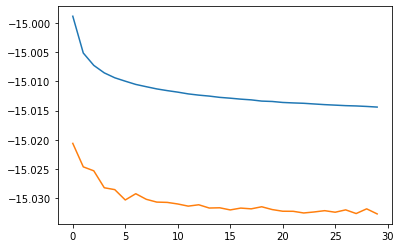

In [51]:
distiller.distile_student(30)

In [ ]:
# student_model.load_state_dict(torch.load('/content/models/student.pt'))

In [ ]:
# teacher_model.load_state_dict(torch.load('/content/models/teacher.pt'))

In [ ]:
# distilled_student_model.load_state_dict(torch.load('/content/models/student_distil.pt'))

In [ ]:
# distiller = KD(teacher_model, student_model, distilled_student_model, train_loader, test_loader)

In [52]:
distiller.get_parameters()

--------------------------------------------------------------------------------
teacher'parameters : 19357706
student'parameters : 1771786
Percentage of Student/Teacher is: 9.15 %


In [53]:
teacher_acc = distiller.evaluate_teacher()
print(f"Teacher Accuracy: {teacher_acc:0.4}")

Teacher Accuracy: 0.899


In [54]:
student_acc = distiller.evaluate_student(distiled=False)
print(f"Student Accuracy: {student_acc:0.4}")

Student Accuracy: 0.869


In [55]:
distiled_acc = distiller.evaluate_student(distiled=True)
print(f"Distilled Student Accuracy: {distiled_acc:0.4}")

Distilled Student Accuracy: 0.8827
